In [63]:
# only install if not already installed
!pip install yellowbrick 

In [64]:
import pandas as pd
import numpy as np
import plotly.express as px

import matplotlib.pyplot as plt

from sklearn import tree
from sklearn import model_selection
from sklearn.linear_model import LinearRegression

import seaborn as sb

from sklearn.ensemble import RandomForestClassifier

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from scipy.spatial.distance import cdist
from yellowbrick.cluster import SilhouetteVisualizer
import sklearn.metrics as sm
from sklearn import metrics
from sklearn.metrics import silhouette_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.tree import export_text, plot_tree

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

In [65]:
data = pd.read_csv("Data/vgchartz-2024.csv")

In [66]:
# show all columns
pd.set_option("display.max_columns", None)

In [67]:
data.shape

(64016, 14)

In [68]:
data.head()

,img,title,console,genre,publisher,developer,critic_score,total_sales,na_sales,jp_sales,pal_sales,other_sales,release_date,last_update
0,/games/boxart/full_6510540AmericaFrontccc.jpg,Grand Theft Auto V,PS3,Action,Rockstar Games,Rockstar North,9.4,20.32,6.37,0.99,9.85,3.12,2013-09-17,NaN
1,/games/boxart/full_5563178AmericaFrontccc.jpg,Grand Theft Auto V,PS4,Action,Rockstar Games,Rockstar North,9.7,19.39,6.06,0.60,9.71,3.02,2014-11-18,2018-01-03
2,/games/boxart/827563ccc.jpg,Grand Theft Auto: Vice City,PS2,Action,Rockstar Games,Rockstar North,9.6,16.15,8.41,0.47,5.49,1.78,2002-10-28,NaN
3,/games/boxart/full_9218923AmericaFrontccc.jpg,Grand Theft Auto V,X360,Action,Rockstar Games,Rockstar North,NaN,15.86,9.06,0.06,5.33,1.42,2013-09-17,NaN
4,/games/boxart/full_4990510AmericaFrontccc.jpg,Call of Duty: Black Ops 3,PS4,Shooter,Activision,Treyarch,8.1,15.09,6.18,0.41,6.05,2.44,2015-11-06,2018-01-14


## General Cleaning

The different questions require different cleaning, so we start with a general cleaning, and clean for each question as needed

In [69]:
# We dont need the "Last_update" and the "img" column for any of our research
    
data_general_clean = data.copy()

data_general_clean = data_general_clean.drop(["last_update", "img"], axis=1)

In [70]:
data_general_clean.isnull().sum()

title               0
console             0
genre               0
publisher           0
developer          17
critic_score    57338
total_sales     45094
na_sales        51379
jp_sales        57290
pal_sales       51192
other_sales     48888
release_date     7051
dtype: int64

In [71]:
data_general_clean.duplicated().sum()

np.int64(21)

In [72]:
# all of our questions is based on sale to validate the hypothesis, therefor we will drop all that dont have that data.

data_general_clean = data_general_clean.dropna(subset=["total_sales"])

In [73]:
data_general_clean.shape

(18922, 12)

In [74]:
data_general_clean.sample(5)


,title,console,genre,publisher,developer,critic_score,total_sales,na_sales,jp_sales,pal_sales,other_sales,release_date
1091,Lara Croft Tomb Raider: The Angel of Darkness,PS2,Action,Eidos Interactive,Core Design Ltd.,NaN,1.25,0.61,NaN,0.48,0.16,2003-06-20
13804,Clock Zero: Shuuen no Ichibyou Portable,PSP,Adventure,Idea Factory,Unknown,NaN,0.04,NaN,0.04,NaN,NaN,2011-10-13
1670,Crysis 3,X360,Shooter,Electronic Arts,Crytek,7.6,0.92,0.51,0.01,0.32,0.08,2013-02-19
955,Skylanders SWAP Force,X360,Platform,Activision,Unknown,NaN,1.36,0.88,NaN,0.35,0.13,2013-10-13
10417,Kirarin * Revolution: Mezase! Idol Queen,DS,Simulation,Konami,Konami,NaN,0.10,NaN,0.10,NaN,NaN,2007-07-12


In [75]:
data_general_clean.isnull().sum()

title               0
console             0
genre               0
publisher           0
developer           4
critic_score    14796
total_sales         0
na_sales         6285
jp_sales        12196
pal_sales        6098
other_sales      3794
release_date       90
dtype: int64

In [76]:
# we figure that if there are total sales, and none in the others sale colmuns, it properly means that 
# there somewhere is somthing round down, but the total sale is still valied
data_general_clean[["na_sales", "jp_sales", "pal_sales", "other_sales"]] = data_general_clean[["na_sales", "jp_sales", "pal_sales", "other_sales"]].fillna(0)

In [77]:
data_general_clean.isnull().sum()

title               0
console             0
genre               0
publisher           0
developer           4
critic_score    14796
total_sales         0
na_sales            0
jp_sales            0
pal_sales           0
other_sales         0
release_date       90
dtype: int64

In [78]:
# It's easier for us to visualize with a year and month seperate.
data_general_clean_date = data_general_clean.copy()

data_general_clean_date["release_date"] = pd.to_datetime(data_general_clean_date["release_date"])

data_general_clean_date["month"] = data_general_clean_date["release_date"].dt.month.astype("Int64")
data_general_clean_date["year"] = data_general_clean_date["release_date"].dt.year.astype("Int64")

data_general_clean_date.sample(5)

,title,console,genre,publisher,developer,critic_score,total_sales,na_sales,jp_sales,pal_sales,other_sales,release_date,month,year
4491,NBA 2K10,Wii,Sports,2K Sports,Visual Concepts,5.1,0.37,0.34,0.00,0.00,0.03,2009-11-09,11,2009
3652,Boom Blox Bash Party,Wii,Puzzle,Electronic Arts,EA Los Angeles,8.8,0.46,0.33,0.00,0.09,0.04,2009-05-19,5,2009
7159,Warriors Orochi,X360,Action,KOEI,Omega Force,NaN,0.20,0.17,0.00,0.01,0.02,2007-09-18,9,2007
6716,All Star Karate,Wii,Action,THQ,THQ,NaN,0.22,0.13,0.00,0.07,0.02,2010-04-20,4,2010
13426,Hero Must Die,PSV,Role-Playing,Nippon Ichi Software,Pyramid,NaN,0.04,0.00,0.04,0.00,0.00,2016-02-25,2,2016


In [79]:
# now when we have date and year in seperate colmuns we drop the release_date
data_general_clean_date = data_general_clean_date.dropna(subset=['release_date'])
data_general_clean_date.isnull().sum()

title               0
console             0
genre               0
publisher           0
developer           3
critic_score    14709
total_sales         0
na_sales            0
jp_sales            0
pal_sales           0
other_sales         0
release_date        0
month               0
year                0
dtype: int64

In [80]:
data_general_clean.describe()

,critic_score,total_sales,na_sales,jp_sales,pal_sales,other_sales
count,4126.000000,18922.000000,18922.000000,18922.000000,18922.000000,18922.000000
mean,7.101890,0.349113,0.176806,0.036357,0.101302,0.034411
std,1.439307,0.807462,0.423133,0.111918,0.330707,0.114541
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,6.300000,0.030000,0.000000,0.000000,0.000000,0.000000
50%,7.300000,0.120000,0.050000,0.000000,0.010000,0.010000
75%,8.100000,0.340000,0.170000,0.020000,0.070000,0.020000
max,10.000000,20.320000,9.760000,2.130000,9.850000,3.120000


## Question 1: When should a company release a game to maximize sales at launch?

In [81]:
data_general_clean_date_q1 = data_general_clean_date.copy()

In [82]:
# Convert month names to numbers if they're currently text
month_mapping = {
    "Jan": 1, "Feb": 2, "Mar": 3, "Apr": 4, "May": 5, "Jun": 6,
    "Jul": 7, "Aug": 8, "Sep": 9, "Oct": 10, "Nov": 11, "Dec": 12
}

# Create a numeric month column if needed
if data_general_clean_date_q1['month'].dtype == 'object':
    data_general_clean_date_q1['month_num'] = data_general_clean_date_q1['month'].map(month_mapping)
else:
    data_general_clean_date_q1['month_num'] = data_general_clean_date_q1['month']

# Calculate the maximum y value across all years to fix the scale
max_sales = data_general_clean_date_q1.groupby(['year', 'month_num'])['total_sales'].sum().max()

# Base arguments for histogram
kwargs = {
    "x": "month_num",  # Use numeric month
    "y": "total_sales",
    "animation_frame": "year",
    "histfunc": "sum",
    "labels": {
        "total_sales": "Sales",
        "month_num": "Release Month",
        "year": "Release Year"
    },
    "title": "Monthly Release Histogram Animated by Year and Total Accumulated Sales"
}

if "category" in data_general_clean_date_q1.columns:
    kwargs["color"] = "category"

fig = px.histogram(data_general_clean_date_q1, **kwargs)

fig.update_yaxes(range=[0, max_sales * 1.1])
fig.update_xaxes(
    range=[0.5, 12.5],  # Fixed range for months 1-12
    tickmode='linear',
    tick0=1,
    dtick=1  # Show every month
)

# Reverse year order so animation starts at oldest year
fig.layout.updatemenus[0].buttons[0].args[1]["frame"]["duration"] = 1000
fig.frames = sorted(fig.frames, key=lambda f: int(f.name))
fig.layout.sliders[0]["steps"] = sorted(fig.layout.sliders[0]["steps"], key=lambda s: int(s["label"]))

fig.show()

The Months and years shows when the game was released, not the date of the sale. Sales are measured accumulatively. But we assume that sales are highest around the release date.
We can see a trend in later years around the month 10 and 11, which we speculate sales leading up to Christmas(the holidays). We can also see a slight trend around month 3 (March), we speculate that a lot of our data comes from games sold for NA. This could possibly be explained by holidays in NA, for example Spring break.

In [83]:
# Group by year and month, count rows
games_per_month = (
    data_general_clean_date_q1.groupby(["year", "month"])
      .size()
      .reset_index(name="count")
)

# Calculate max count for fixed y-axis
max_count = games_per_month["count"].max()

# Convert month to numeric if it isn't already
if games_per_month["month"].dtype == 'object':
    month_mapping = {
        "Jan": 1, "Feb": 2, "Mar": 3, "Apr": 4, "May": 5, "Jun": 6,
        "Jul": 7, "Aug": 8, "Sep": 9, "Oct": 10, "Nov": 11, "Dec": 12
    }
    games_per_month["month"] = games_per_month["month"].map(month_mapping)

# Ensure month is integer
games_per_month["month"] = games_per_month["month"].astype(int)

# Create animated bar chart
fig = px.bar(
    games_per_month,
    x="month",
    y="count",
    animation_frame="year",
    labels={
        "count": "Number of Games",
        "month": "Release Month",
        "year": "Release Year"
    },
    title="Number of Games Released per Month (Animated by Year)"
)

# Fix both axes
fig.update_yaxes(range=[0, max_count * 1.1])  # Add 10% padding
fig.update_xaxes(
    range=[0.5, 12.5],
    tickmode='linear',
    tick0=1,
    dtick=1,
    tickvals=list(range(1, 13))  # Explicitly show 1-12
)

# Sort frames by year
fig.layout.updatemenus[0].buttons[0].args[1]["frame"]["duration"] = 1000
fig.frames = sorted(fig.frames, key=lambda f: int(f.name))
fig.layout.sliders[0]["steps"] = sorted(fig.layout.sliders[0]["steps"], key=lambda s: int(s["label"]))

fig.show()

We want to see how many games are released over the years for specific months, to compare with the previous animation for sales, but the sales are reported as acumelated over the years, but we figure that most of the sales come from the release period.

Based on the 2 visualizations, we can conclude, that the months that most game are released in, thats aproximately the same months with best sales. 

### Hypothesis for question 1: 
We assume that games sell better during certain periods of the year compared to others. Therefore, we expect to observe a trend where games released in those periods achieve higher sales.

### Observartion:
We can see that there are trends to when games are released and high sales are recorded, march, june but mostly september, october and november. We assume that is due to most of our data comes from north america, and its properly due to black friday and holidays


## Question 2: Do video games form distinct clusters based on release period (old vs. new) and sales performance (high vs. low)?

In [84]:
data_general_clean_q2 = data_general_clean_date.copy()

data_general_clean_q2 = data_general_clean_date[["year", "month", "total_sales"]].copy()

data_general_clean_q2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 18832 entries, 0 to 18921
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   year         18832 non-null  Int64  
 1   month        18832 non-null  Int64  
 2   total_sales  18832 non-null  float64
dtypes: Int64(2), float64(1)
memory usage: 625.3 KB


In [85]:
data_general_clean_q2 = data_general_clean_q2.dropna(subset=["year", "month"])

data_general_clean_q2["date"] = pd.to_datetime(dict(year=data_general_clean_q2["year"], month=data_general_clean_q2["month"], day=1))

# Sort by date just in case
data_general_clean_q2 = data_general_clean_q2.sort_values("date")

data_general_clean_q2_2 = data_general_clean_q2[["date", "total_sales"]].copy()

data_general_clean_q2_2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 18832 entries, 1102 to 14310
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   date         18832 non-null  datetime64[ns]
 1   total_sales  18832 non-null  float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 441.4 KB


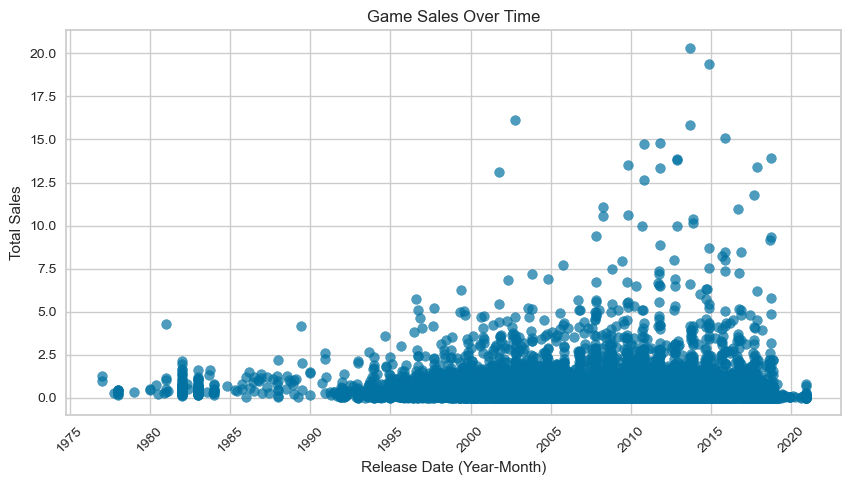

In [86]:
X_clustering = data_general_clean_q2_2.values

plt.figure(figsize=(10,5))
plt.scatter(data_general_clean_q2_2["date"], data_general_clean_q2_2["total_sales"], marker="o", s=50, alpha=0.7)
plt.xlabel("Release Date (Year-Month)")
plt.ylabel("Total Sales")
plt.title("Game Sales Over Time")
plt.xticks(rotation=45)
plt.show()

The video games does cluster based on age and sales, but since allmost all the sales is between 0 and 5 it is difficult to create a meaningful clustering model with this data. this is partly due to many of our obsevations is based only 2 decimals, so small games gets lost.

In [87]:
data_general_clean_q2['date_numeric'] = (data_general_clean_q2['date'] - data_general_clean_q2['date'].min()).dt.days


X_clustering = data_general_clean_q2[['date_numeric', 'total_sales']].values


scaler = StandardScaler()
X_clustering_scaled = scaler.fit_transform(X_clustering)

In [88]:
distortions = []
K = range(2, 12)
for k in K:
    model = KMeans(n_clusters=k, n_init=10, random_state=42)
    model.fit(X_clustering_scaled)
    distortions.append(
        sum(np.min(cdist(X_clustering_scaled, model.cluster_centers_, 'euclidean'), axis=1)) / X_clustering_scaled.shape[0]
    )

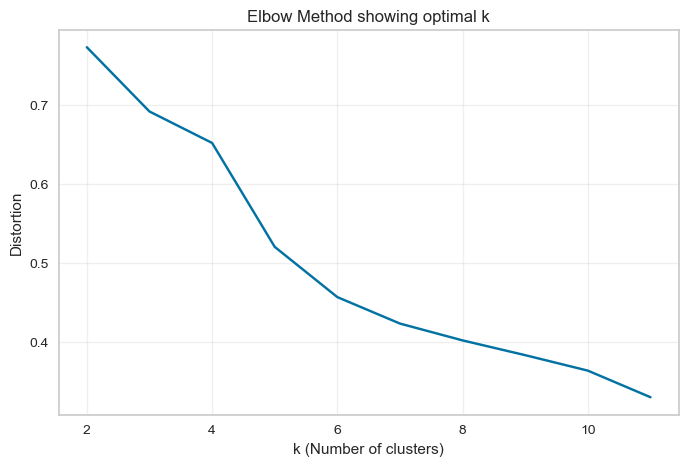

In [89]:
plt.figure(figsize=(8,5))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k (Number of clusters)')
plt.ylabel('Distortion')
plt.title('Elbow Method showing optimal k')
plt.grid(True, alpha=0.3)
plt.show()

In [90]:
optimal_k = 4
final_model = KMeans(n_clusters=optimal_k, n_init=10, random_state=42)
data_general_clean_q2['cluster'] = final_model.fit_predict(X_clustering_scaled)

### Determin K by Silhouette Score

In [91]:
# Determine k by maximising the silhouette score for each number of clusters
scores = []
K = range(2,10)
for k in K:
    model = KMeans(n_clusters=k, n_init=10)
    model.fit(X_clustering_scaled)
    score = metrics.silhouette_score(X_clustering_scaled, model.labels_, metric='euclidean', sample_size=len(X_clustering_scaled))
    print("\nNumber of clusters =", k)
    print("Silhouette score =", score)
    scores.append(score)


Number of clusters = 2
Silhouette score = 0.4379766530718718

Number of clusters = 3
Silhouette score = 0.4515878015476791

Number of clusters = 4
Silhouette score = 0.4662756905042828

Number of clusters = 5
Silhouette score = 0.44873113375482365

Number of clusters = 6
Silhouette score = 0.43101869911272733

Number of clusters = 7
Silhouette score = 0.4493745719399297

Number of clusters = 8
Silhouette score = 0.44553581014719434

Number of clusters = 9
Silhouette score = 0.45576497037310554


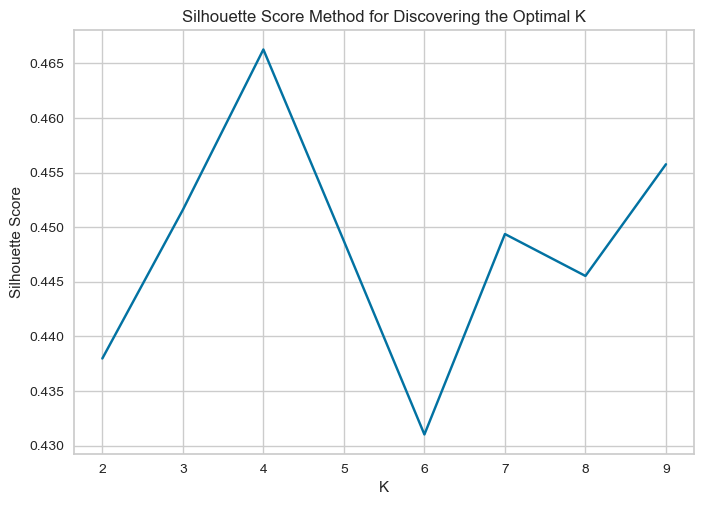

In [92]:
plt.title('Silhouette Score Method for Discovering the Optimal K')
plt.plot(K, scores, 'bx-')
plt.xlabel('K')
plt.ylabel('Silhouette Score')
plt.show()

The diagram shows that the optimal amount of clusters is 4 because it has the highest score of 0.46, but is a weak structure, but close to the 0,5 which is consider a fair structure

In [93]:
optimal_k = 4

In [94]:
kmeans = KMeans(init='k-means++', n_clusters=optimal_k, n_init=20)
# init: method of experimemtal finding the initial location of the centroids
# n_init: the algorithm will run n_init times with different cetroids and the best result of those will be taken

In [95]:
kmeans.fit(X_clustering_scaled)

KMeans(n_clusters=4, n_init=20)

In [96]:
y = kmeans.predict(X_clustering_scaled)
y

array([1, 1, 1, ..., 0, 0, 0], dtype=int32)

In [97]:
print(kmeans.labels_)

[1 1 1 ... 0 0 0]


Cluster  0 :  (11221, 2)


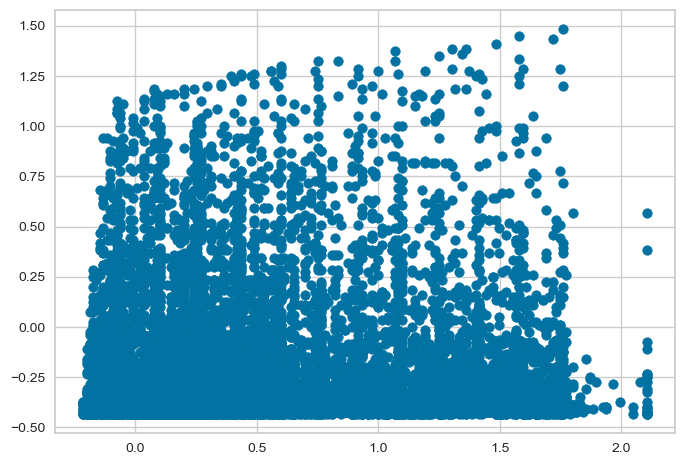

Cluster  1 :  (6750, 2)


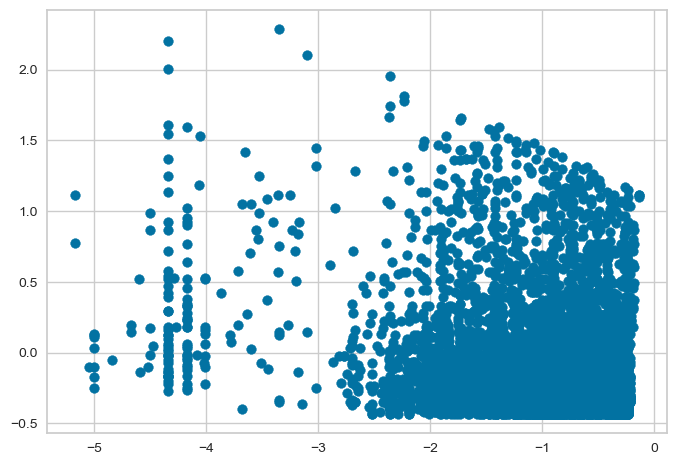

Cluster  2 :  (57, 2)


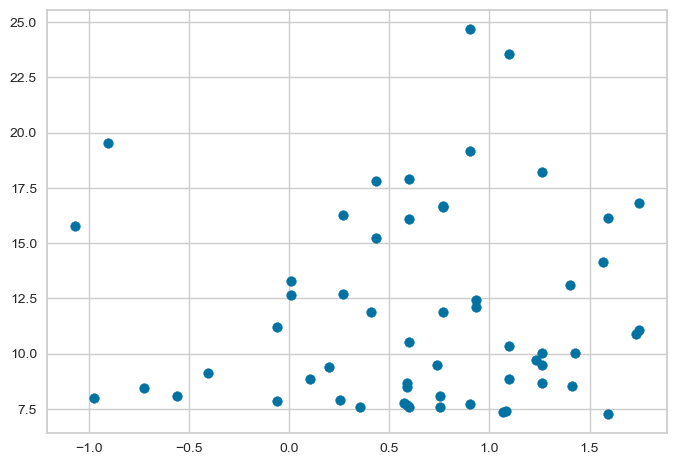

Cluster  3 :  (804, 2)


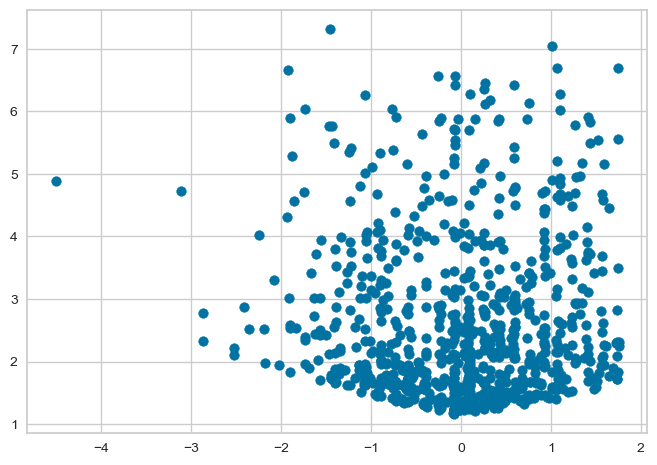

In [98]:
# Clusters seen one by one
for i in range(optimal_k):
    # slice the cluster
    cluster = X_clustering_scaled[y == i]    
    # print the shape
    print("Cluster ", i, ": ", cluster.shape)    
    # plot the points of this cluster
    plt.scatter(cluster[:, 0], cluster[:, 1])   
    plt.grid(True)
    plt.show()

In [99]:
from matplotlib.colors import ListedColormap
cluster_colors = ['#6a0dad', '#ff7f0e', '#1f77b4', '#2ca02c']

cmap = ListedColormap(cluster_colors)

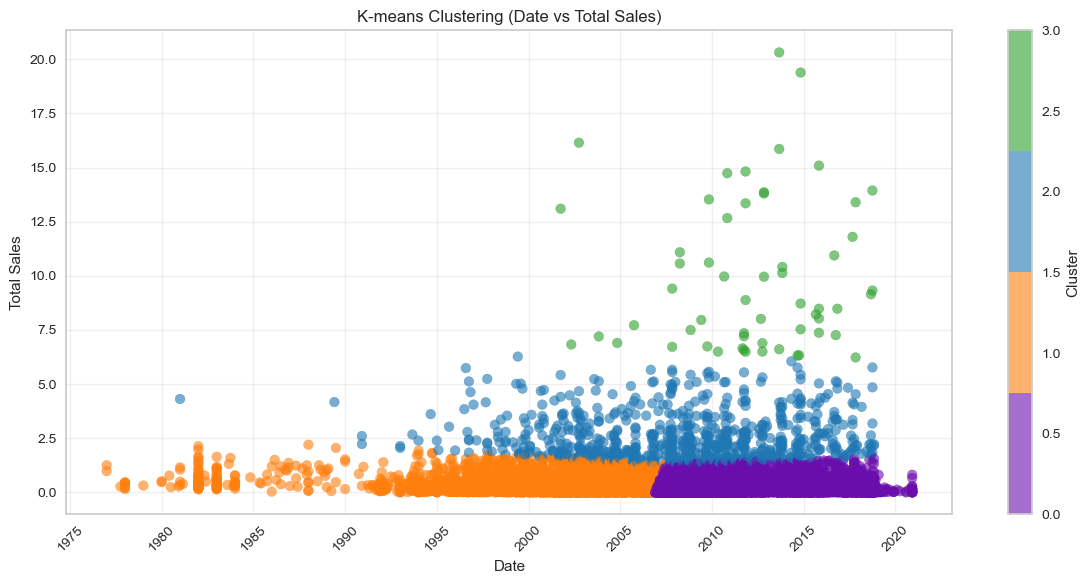

In [100]:
plt.figure(figsize=(12,6))
scatter = plt.scatter(data_general_clean_q2['date'], 
                     data_general_clean_q2['total_sales'], 
                     c=data_general_clean_q2['cluster'], 
                     cmap=cmap, 
                     alpha=0.6)
plt.xlabel('Date')
plt.ylabel('Total Sales')
plt.title('K-means Clustering (Date vs Total Sales)')
plt.colorbar(scatter, label='Cluster')
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [101]:
# See the cluster centres, created during the clustering
# cluster centres are stored in a variable named 'cluster_centers_'
print(kmeans.cluster_centers_)

[[ 5.99950889e-01 -1.91381954e-01]
 [-1.00546265e+00 -1.00028993e-01]
 [ 6.62406584e-01  1.18316709e+01]
 [ 5.47453530e-03  2.66237348e+00]]


### Validate the model

In [102]:
k = 4
KmeansModel = KMeans(n_clusters=k, n_init=10)
KmeansModel.fit_predict(X_clustering_scaled)

array([2, 2, 2, ..., 0, 0, 0], dtype=int32)

In [103]:
score = silhouette_score(X_clustering_scaled, KmeansModel.labels_, metric='euclidean')
print('Silhouette Score: %.3f' % score)

Silhouette Score: 0.466


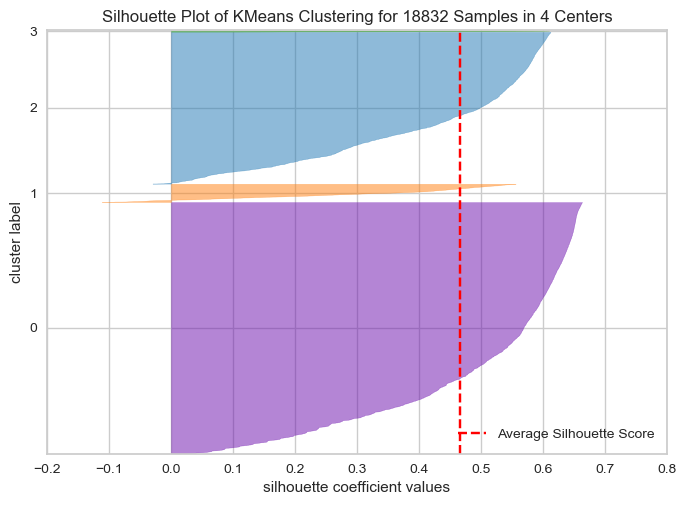

<Axes: title={'center': 'Silhouette Plot of KMeans Clustering for 18832 Samples in 4 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [104]:
visualizer = SilhouetteVisualizer(KmeansModel, colors=cluster_colors)
visualizer.fit(X_clustering_scaled)
visualizer.show()
# TODO Fix Color - colors does not correlate with above

Interpretation: Each component of the figure represents one cluster with a horisontal bar chart of each cluster point.
Clusters are seen are far from equaly tick and long - similar.
The score is 0.46 - which states that the structure is weak.


### Hypothesis for question 2: 
We expect video games can be clustered into meaningful groups according to their age and sales success.

### Observartion:
We can use this clustering model to help categorize different games based on their sales. We can as an example look at games in the cluster for high sales and study that type of game to see what they do differently compared to games that are placed in the lower sales cluster.

At the same time we can potetially use older and "high" selling games to see if there is a trend that still persist in newer high selling games

## Question 3: Which consoles should a specific genre game be developed for optimzed sales?

In [105]:
data_general_clean_date_q3 = data_general_clean_date.copy()

all_consoles = data_general_clean_date_q3['console'].unique()
all_genres = data_general_clean_date_q3['genre'].unique()

full_index = pd.MultiIndex.from_product([all_genres, all_consoles], names=['genre', 'console'])

# Group your data by genre and console, summing sales
sales_summary = data_general_clean_date_q3.groupby(['genre', 'console'])['total_sales'].sum()

# Reindex to include all combinations, fill missing with 0
sales_summary = sales_summary.reindex(full_index, fill_value=0).reset_index()

In [106]:
# Determine the maximum sales across all genre-console combinations
max_sales = sales_summary['total_sales'].max()

In [107]:
fig = px.bar(
    sales_summary,
    x="console",
    y="total_sales",
    animation_frame="genre",
    labels={
        "total_sales": "Total Sales",
        "console": "Console",
        "genre": "Genre"
    },
    title="Sales per Console Animated by Genre"
)

# Keep x-axis fixed with all consoles
fig.update_xaxes(categoryorder="array", categoryarray=list(all_consoles))

fig.update_yaxes(range=[0, max_sales * 1.05])  # small buffer on top

fig.show()

We had expected to see more sales for PC, we speculate the dataset is incomplete and doesn't reflect the real world scenario in this case. We had previously cleaned the dataset and there were thousands of rows with no data for sales, which we removed.

In [108]:
data_general_clean_date_q3 = data_general_clean_date.copy()
hardware_map = {
    # Home consoles
    "PS": "Home Console", "PS2": "Home Console", "PS3": "Home Console", "PS4": "Home Console",
    "XB": "Home Console", "X360": "Home Console", "XOne": "Home Console",
    "Wii": "Home Console", "WiiU": "Home Console", "NES": "Home Console", "SNES": "Home Console",
    "N64": "Home Console", "GC": "Home Console", "SAT": "Home Console", "DC": "Home Console",
    "GEN": "Home Console", "2600": "Home Console", "3DO": "Home Console",
    "SCD": "Home Console", "PCE": "Home Console", "NG": "Home Console",
    "VC": "Home Console", "NS": "Home Console",

    # Handheld
    "GB": "Handheld", "GBC": "Handheld", "GBA": "Handheld", "DS": "Handheld", "3DS": "Handheld",
    "PSP": "Handheld", "PSV": "Handheld", "GG": "Handheld", "WS": "Handheld",

    # PC/Mobile
    "PC": "PC/Mobile", "OSX": "PC/Mobile", "Mob": "PC/Mobile", "PCFX": "PC/Mobile",
    "PSN": "PC/Mobile", "XBL": "PC/Mobile"
}

data_general_clean_date_q3["hardware"] = data_general_clean_date_q3["console"].map(hardware_map)

data_general_clean_date_q3["hardware"] = data_general_clean_date_q3["hardware"].fillna("Other")

data_general_clean_date_q3.sample(5)

,title,console,genre,publisher,developer,critic_score,total_sales,na_sales,jp_sales,pal_sales,other_sales,release_date,month,year,hardware
9751,Legend of the Guardians: The Owls of Ga'Hoole,Wii,Action,Warner Bros. Interactive,Krome Studios,NaN,0.11,0.10,0.00,0.01,0.01,2010-09-14,9,2010,Home Console
7216,Taiko no Tatsujin: Wii U Version!,WiiU,Music,Namco Bandai Games,Bandai Namco Games,NaN,0.19,0.00,0.19,0.00,0.00,2013-11-21,11,2013,Home Console
9981,Zero Escape: Zero Time Dilemma,PSV,Adventure,Aksys Games,Chime,NaN,0.11,0.06,0.04,0.00,0.02,2016-06-28,6,2016,Handheld
11984,D.C. II P.S.: Da Capo II Plus Situation,PS2,Adventure,Kadokawa Shoten,Circus,NaN,0.06,0.00,0.06,0.00,0.00,2008-05-29,5,2008,Home Console
252,Call of Duty: Ghosts,XOne,Shooter,Activision,Infinity Ward,7.5,3.07,1.92,0.00,0.86,0.28,2013-11-22,11,2013,Home Console


In [109]:
genre_sales = (
    data_general_clean_date_q3.groupby(["genre", "hardware"])["total_sales"]
    .mean()
    .reset_index()
)

# Sortér så det er nemt at aflæse
genre_sales_sorted = genre_sales.sort_values(
    by=["genre", "total_sales"], ascending=[True, False]
)

print("Gennemsnitligt salg pr. genre + hardware (sorteret):")
print(genre_sales_sorted)

# Hvis du kun vil have 'vinderne' (top 1 hardware pr. genre):
best_console_per_genre = genre_sales_sorted.groupby("genre").head(1)

print("\nBedste hardware pr. genre:")
print(best_console_per_genre)

Gennemsnitligt salg pr. genre + hardware (sorteret):
               genre      hardware  total_sales
1             Action  Home Console     0.522489
0             Action      Handheld     0.205721
2             Action     PC/Mobile     0.072000
4   Action-Adventure  Home Console     0.675678
5   Action-Adventure     PC/Mobile     0.228333
3   Action-Adventure      Handheld     0.213585
7          Adventure  Home Console     0.235514
6          Adventure      Handheld     0.139437
8          Adventure     PC/Mobile     0.035838
9         Board Game  Home Console     0.110000
11         Education  Home Console     0.293333
10         Education      Handheld     0.090000
13          Fighting  Home Console     0.450275
12          Fighting      Handheld     0.175247
14          Fighting     PC/Mobile     0.031538
16               MMO  Home Console     0.360476
17               MMO     PC/Mobile     0.196250
15               MMO      Handheld     0.170000
19              Misc  Home Console 

### Hypothesis for question 3:

We assume that certain game genres sell better on specific consoles. Therefore, we expect to see a significantly larger number of sales from a specific genre on those consoles.

### Observartion:
We can conclude from our data that developing games for home consoles will give the best possible sales, it is however important to note that our dataset shows clear holes in the data, with high possibility of missing data for PC releases/sales wich gives a skewed view that favors console releases.



## Question 4: How can trends be predicted so that a game is released when its genre is popular? 

In [110]:
sales_summary_q4 = (
    data_general_clean_date.groupby(['year', 'genre'], as_index=False)['total_sales'].sum()
)

all_years = sales_summary_q4['year'].unique()
all_genres = sales_summary_q4['genre'].unique()

# Create full combination of year x genre
full_index = pd.MultiIndex.from_product([all_years, all_genres], names=['year', 'genre'])
sales_summary_q4 = sales_summary_q4.set_index(['year','genre']).reindex(full_index, fill_value=0).reset_index()

fig = px.bar(
    sales_summary_q4,
    x="year",
    y="total_sales",
    animation_frame="genre",
    labels={
        "total_sales": "Total Sales",
        "year": "Release Year",
        "genre": "Game Genre"
    },
    title="Total Game Sales per Year Animated by Genre",
    color="genre"  # optional, or remove if you don’t want color distinction
)

# Fix x-axis so all years are always shown
fig.update_xaxes(categoryorder="array", categoryarray=sorted(all_years))

# Optionally fix y-axis so bars don’t get cut off
fig.update_yaxes(range=[0, sales_summary_q4['total_sales'].max() * 1.05])

fig.show()


### Hypothesis for question 4:

We assume that some game genres follow a popularity cycle, and we expect to identify patterns in when specific genres become popular.

### Observartion:
We can see that aren't really any yearly trends for genres of games, we can generally see that there are some genres that are more popular than others.

We can see that some genres used to be popular, but no longer are, such as "racing". On the other hand there are some other genres still popular, such as shooter. (note that our data cuts off at 2018). 

## Question 5: Which game genres sell better in which regions, so that companies know where to market their games?

In [111]:
# Columns that represent regions
region_columns = ['na_sales', 'jp_sales', 'pal_sales', 'other_sales']

# Melt into long format: region + sales
df_long = data_general_clean_date.melt(
    id_vars=['title','console','genre','publisher','developer','critic_score', 'total_sales' ,'release_date'],
    value_vars=region_columns,
    var_name='region',
    value_name='sales'
)

# Optional: make region names prettier
df_long['region'] = df_long['region'].str.replace('_sales', '').str.upper()

sales_summary_q4 = df_long.groupby(['genre','region'], as_index=False)['sales'].sum()

all_genres = data_general_clean_date['genre'].unique()
all_regions = ['NA','JP','PAL','OTHER']

full_index = pd.MultiIndex.from_product([all_genres, all_regions], names=['genre','region'])
sales_summary_q4 = sales_summary_q4.set_index(['genre','region']).reindex(full_index, fill_value=0).reset_index()

fig = px.bar(
    sales_summary_q4,
    x="genre",
    y="sales",
    animation_frame="region",
    labels={
        "sales": "Total Sales",
        "genre": "Game Genre",
        "region": "Region"
    },
    title="Total Game Sales by Genre Animated by Region",
    color="genre"
)

# Keep x-axis fixed
fig.update_xaxes(categoryorder="array", categoryarray=list(all_genres))

# Fix y-axis so bars are never cut off
fig.update_yaxes(range=[0, sales_summary_q4['sales'].max() * 1.05])

fig.show()

### Hypothesis for question 5:
We assume that some game genres sell better in specific regions.

### Observartion:
We can see that the NA region has higher sells in all genres, JP and OTHER has almost none and PAL has a few. So we can conclude that all genres will most likely sell better in NA. And while Action, shooter and Sports are highest in every almost every region, it seems that JP is mostly into Role-Playing.

## Question 6: Can we predict the sales of a game based on the different categorical values in the dataset before it launches?

In [112]:
data_general_clean_q6 = data_general_clean_date[["console","genre", "publisher", "developer", "month", "year", "total_sales"]].copy()

In [113]:
categorical_cols = ["console", "genre", "publisher", "developer"]

data_encoded = pd.get_dummies(data_general_clean_q6, columns=categorical_cols)

data_encoded = data_encoded.astype(float)
data_encoded.head()

month    year  total_sales  console_2600  console_3DO  console_3DS  \
0    9.0  2013.0        20.32           0.0          0.0          0.0   
1   11.0  2014.0        19.39           0.0          0.0          0.0   
2   10.0  2002.0        16.15           0.0          0.0          0.0   
3    9.0  2013.0        15.86           0.0          0.0          0.0   
4   11.0  2015.0        15.09           0.0          0.0          0.0   

   console_DC  console_DS  console_GB  console_GBA  console_GBC  console_GC  \
0         0.0         0.0         0.0          0.0          0.0         0.0   
1         0.0         0.0         0.0          0.0          0.0         0.0   
2         0.0         0.0         0.0          0.0          0.0         0.0   
3         0.0         0.0         0.0          0.0          0.0         0.0   
4         0.0         0.0         0.0          0.0          0.0         0.0   

   console_GEN  console_GG  console_Mob  console_N64  console_NES  console_NG  \
0          0.0         0.0          0.0          0.0          0.0         0.0   
1          0.0         0.0          0.0          0.0          0.0         0.0   
2          0.0         0.0          0.0          0.0          0.0         0.0   
3          0.0         0.0          0.0          0.0          0.0         0.0   
4          0.0         0.0          0.0          0.0          0.0         0.0   

   console_NS  console_OSX  console_PC  console_PCE  console_PCFX  console_PS  \
0         0.0          0.0         0.0          0.0           0.0         0.0   
1         0.0          0.0         0.0          0.0           0.0         0.0   
2         0.0          0.0         0.0          0.0           0.0         0.0   
3         0.0          0.0         0.0          0.0           0.0         0.0   
4         0.0          0.0         0.0          0.0           0.0         0.0   

   console_PS2  console_PS3  console_PS4  console_PSN  console_PSP  \
0          0.0          1.0          0.0          0.0          0.0   
1          0.0          0.0          1.0          0.0          0.0   
2          1.0          0.0          0.0          0.0          0.0   
3          0.0          0.0          0.0          0.0          0.0   
4          0.0          0.0          1.0          0.0          0.0   

   console_PSV  console_SAT  console_SCD  console_SNES  console_VC  \
0          0.0          0.0          0.0           0.0         0.0   
1          0.0          0.0          0.0           0.0         0.0   
2          0.0          0.0          0.0           0.0         0.0   
3          0.0          0.0          0.0           0.0         0.0   
4          0.0          0.0          0.0           0.0         0.0   

   console_WS  console_WW  console_Wii  console_WiiU  console_X360  \
0         0.0         0.0          0.0           0.0           0.0   
1         0.0         0.0          0.0           0.0           0.0   
2         0.0         0.0          0.0           0.0           0.0   
3         0.0         0.0          0.0           0.0           1.0   
4         0.0         0.0          0.0           0.0           0.0   

   console_XB  console_XBL  console_XOne  genre_Action  \
0         0.0          0.0           0.0           1.0   
1         0.0          0.0           0.0           1.0   
2         0.0          0.0           0.0           1.0   
3         0.0          0.0           0.0           1.0   
4         0.0          0.0           0.0           0.0   

   genre_Action-Adventure  genre_Adventure  genre_Board Game  genre_Education  \
0                     0.0              0.0               0.0              0.0   
1                     0.0              0.0               0.0              0.0   
2                     0.0              0.0               0.0              0.0   
3                     0.0              0.0               0.0              0.0   
4                     0.0              0.0               0.0              0.0   

   genre_Fightin

In [114]:
array = data_encoded.values

array

array([[9.000e+00, 2.013e+03, 2.032e+01, ..., 0.000e+00, 0.000e+00,
        0.000e+00],
       [1.100e+01, 2.014e+03, 1.939e+01, ..., 0.000e+00, 0.000e+00,
        0.000e+00],
       [1.000e+01, 2.002e+03, 1.615e+01, ..., 0.000e+00, 0.000e+00,
        0.000e+00],
       ...,
       [1.000e+01, 2.004e+03, 0.000e+00, ..., 0.000e+00, 0.000e+00,
        0.000e+00],
       [1.000e+01, 2.002e+03, 0.000e+00, ..., 0.000e+00, 0.000e+00,
        0.000e+00],
       [1.000e+00, 2.007e+03, 0.000e+00, ..., 0.000e+00, 0.000e+00,
        0.000e+00]])

In [115]:
X, y = array[:, :-1], array[:, -1]

In [116]:
max_value = data_general_clean['total_sales'].max()
min_value = data_general_clean['total_sales'].min()

print(f"Max: {max_value}, Min: {min_value}")

Max: 20.32, Min: 0.0


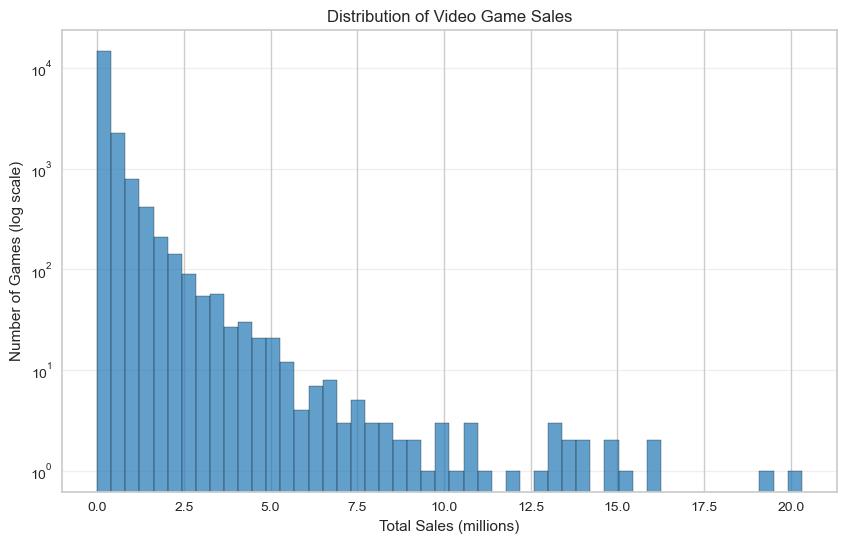

In [117]:
plt.figure(figsize=(10,6))
plt.hist(data_general_clean['total_sales'], bins=50, color='#1f77b4', edgecolor='black', alpha=0.7)
plt.yscale('log')  # log scale on y-axis
plt.xlabel('Total Sales (millions)')
plt.ylabel('Number of Games (log scale)')
plt.title('Distribution of Video Game Sales')
plt.grid(axis='y', alpha=0.3)
plt.show()

In [118]:
bins = [0, 0.2, 0.4, 2, 10, np.inf] 
labels = ['0.2', '0.2-0.4', '0.4-2', '2-10', "10+"]

In [119]:
# Create new classification column
data_encoded['sales_score'] = pd.cut(data_encoded['total_sales'], bins=bins, labels=labels, right=False)

# Convert to numeric for classification
data_encoded['sales_score_numeric'] = pd.cut(data_encoded['total_sales'], bins=bins, labels=False, right=False)

In [120]:
# y = array[:, -1]  # Last column (diag)

# Use your custom classification:
y = data_encoded['sales_score_numeric']
X = data_encoded.drop(['sales_score', 'sales_score_numeric'], axis=1)

### Training

In [121]:
set_prop = 0.15
seed = 8

In [122]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=set_prop, random_state=seed)

In [123]:
classifier = RandomForestClassifier(n_estimators = 100, max_depth = 6, class_weight="balanced", random_state=seed)

In [124]:
classifier.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=6, random_state=8)

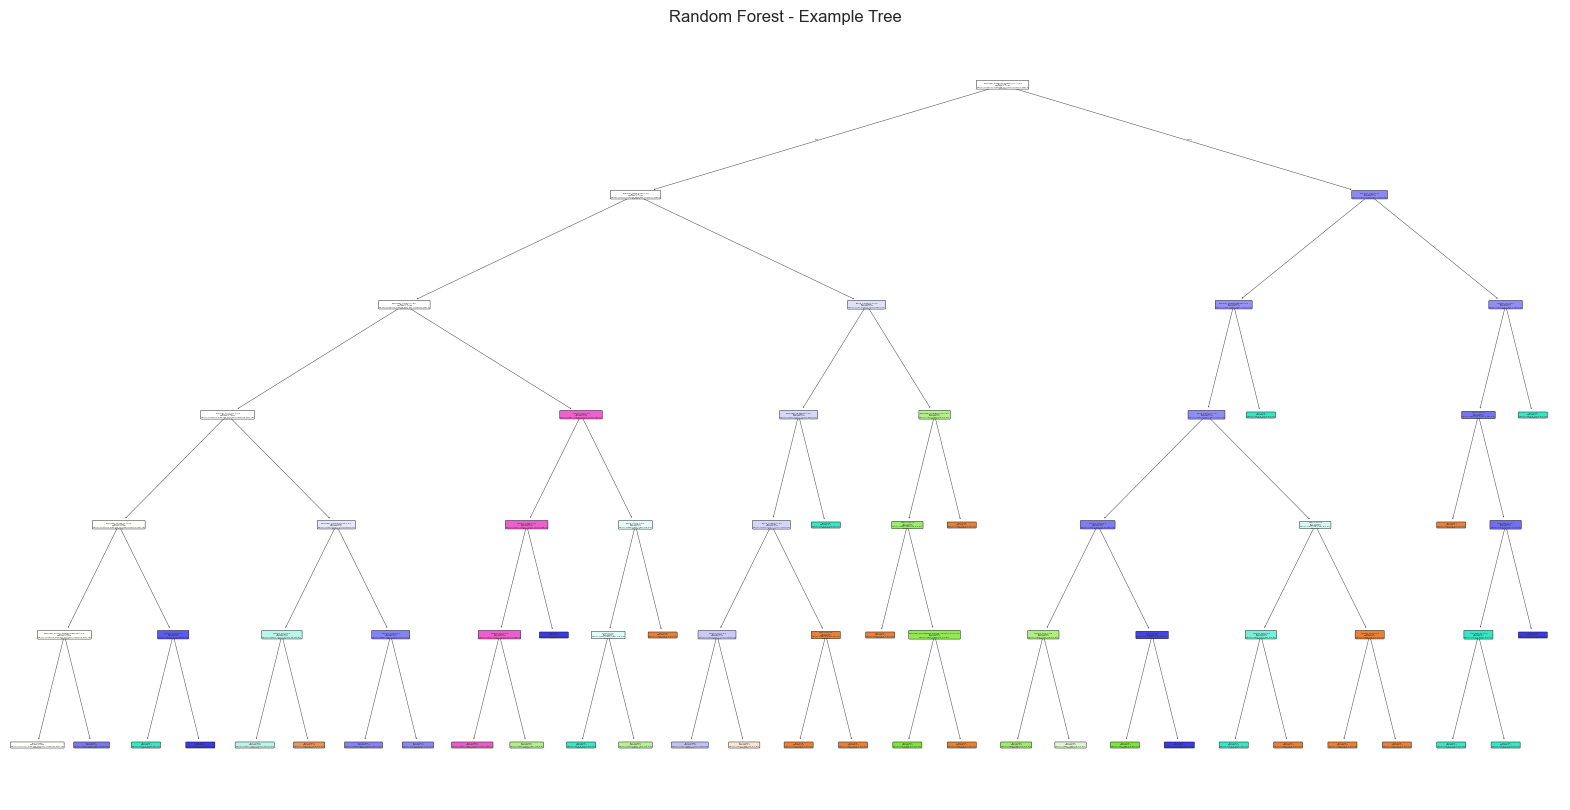

In [125]:
from sklearn.tree import export_text

y = pd.Series(y).astype("category")

# Plot the first tree in the Random Forest
plt.figure(figsize=(20, 10))
plot_tree(
    classifier.estimators_[0],   # first tree in the forest
    feature_names=X.columns,     # feature names
    class_names=[str(cat) for cat in y.cat.categories],  # class names
    filled=True,                 # color the nodes
    rounded=True                 # rounded edges
)
plt.title("Random Forest - Example Tree")
plt.show()

In [157]:
import joblib

# Save model
joblib.dump(classifier, "Models/random_forest_model.pkl")

['Models/random_forest_model.pkl']

### Model Validation

In [127]:
# Set the metrics
scoring = 'accuracy'

In [128]:
# Predict the labels of the test data
y_testp = classifier.predict(X_test)
y_testp

array([1, 1, 0, ..., 0, 0, 1])

In [129]:
# We wanted to see how many we had in each category, to see if it was spaced out enough
print("numbers in cat 0:", (y_testp == 0).sum())
print("numbers in cat 1:",(y_testp == 1).sum())
print("numbers in cat 2:",(y_testp == 2).sum())
print("numbers in cat 3:",(y_testp == 3).sum())
print("numbers in cat 4:", (y_testp == 4).sum())

numbers in cat 0: 1776
numbers in cat 1: 493
numbers in cat 2: 382
numbers in cat 3: 133
numbers in cat 4: 41


In [130]:
y_test

5012     1
4004     2
16671    0
206      3
3076     2
        ..
18085    0
5161     1
11702    0
15545    0
4826     1
Name: sales_score_numeric, Length: 2825, dtype: int64

In [131]:
# Calculated the accuracy of the model comparing the observed data and predicted data
print ("Accuracy is ", accuracy_score(y_test,y_testp))

Accuracy is  0.8902654867256637


In [132]:
# Create confusion matrix
confusion_mat = confusion_matrix(y_test,y_testp)

In [133]:
confusion = pd.crosstab(y_test,y_testp)
confusion

col_0,0,1,2,3,4
sales_score_numeric,,,,,
0,1745,0,0,1,3
1,18,365,16,13,10
2,13,125,353,69,15
3,0,3,13,50,11
4,0,0,0,0,2


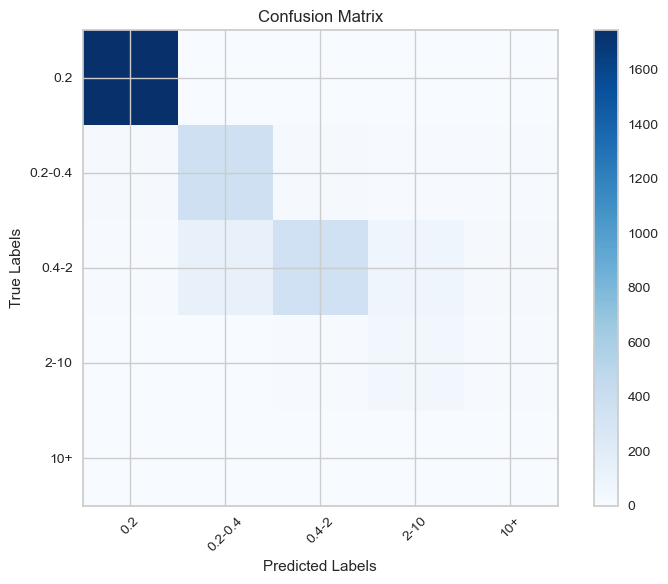

In [134]:
# Visualize confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(confusion_mat, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

# Definer ticks og labels baseret på dine klasser
class_names = ['0.2', '0.2-0.4', '0.4-2', '2-10', '10+']
ticks = np.arange(len(class_names))
plt.xticks(ticks, class_names, rotation=45)
plt.yticks(ticks, class_names)

plt.ylabel('True Labels')
plt.xlabel('Predicted Labels')
plt.tight_layout()
plt.show()

In [135]:
# Define class names for the report
class_names = ['0.2', '0.2-0.4', '0.4-2', '2-10', "10+"]


print("Classification Report (Training Data):")
print(classification_report(y_train, classifier.predict(X_train), target_names=class_names))

print("\nClassification Report (Test Data):")
print(classification_report(y_test, classifier.predict(X_test), target_names=class_names))

# TODO Research this precision, recall, f1, support

Classification Report (Training Data):
              precision    recall  f1-score   support

         0.2       0.99      1.00      0.99      9922
     0.2-0.4       0.80      0.89      0.85      2486
       0.4-2       0.95      0.64      0.77      3152
        2-10       0.39      0.75      0.51       427
         10+       0.08      1.00      0.15        20

    accuracy                           0.91     16007
   macro avg       0.64      0.86      0.65     16007
weighted avg       0.93      0.91      0.91     16007


Classification Report (Test Data):
              precision    recall  f1-score   support

         0.2       0.98      1.00      0.99      1749
     0.2-0.4       0.74      0.86      0.80       422
       0.4-2       0.92      0.61      0.74       575
        2-10       0.38      0.65      0.48        77
         10+       0.05      1.00      0.09         2

    accuracy                           0.89      2825
   macro avg       0.61      0.83      0.62      2825
we

### Hypothesis for question 6:
We assume that the combination of categorical features in the dataset (such as genre, console, publisher, and developer) contains enough information to predict a game’s total sales before launch. Therefore, we expect that a machine learning model, such as a Random Forest, will be able to generate reasonably accurate predictions of sales based solely on these features.

### Observartion:

Even though our model has a high prediction percentage. Most of our prediction accuracy lies in the lower bins and quickly falls off as the bins increase. That could be explain by the lower number of high selling games compared to lower selling.


## Question 7: Does the critic score of a video games have any influence on its sales?

In [136]:
# Copy new dataset and only save the critic_score and total_sales columns
data_general_clean_date_q7 = data_general_clean_date.copy()

data_general_clean_date_q7 = data_general_clean_date_q7.loc[:, ["critic_score", "total_sales"]]

data_general_clean_date_q7 = data_general_clean_date_q7.dropna()

data_general_clean_date_q7.head()

,critic_score,total_sales
0,9.4,20.32
1,9.7,19.39
2,9.6,16.15
4,8.1,15.09
5,8.7,14.82


In [137]:
data_general_clean_date_q7.isnull().sum()

critic_score    0
total_sales     0
dtype: int64

In [138]:
data_general_clean_date_q7.shape

(4123, 2)

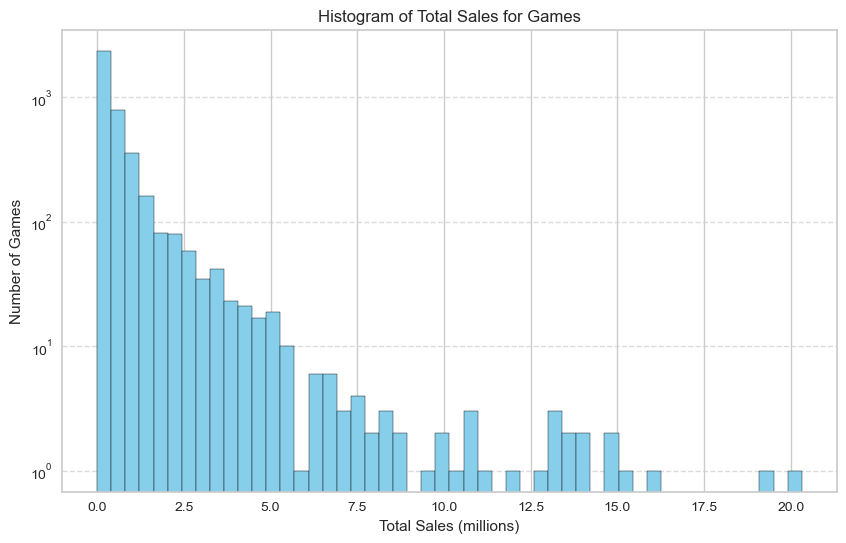

In [139]:
# Assuming your dataset is called data_general_clean_date
# and total_sales column exists
plt.figure(figsize=(10,6))
plt.hist(data_general_clean_date_q7['total_sales'], bins=50, color='skyblue', edgecolor='black')
plt.xlabel("Total Sales (millions)")
plt.ylabel("Number of Games")
plt.title("Histogram of Total Sales for Games")
plt.yscale('log')  # Optional: use log scale if most games have low sales
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

We can see that the distribution of games is heavily skewed towards the lower selling games.

## Train-Test Split

In [140]:
# independent
X = data_general_clean_date_q7['critic_score'].values.reshape(-1, 1) # Uppercase X because we could have multiple columns of X values
# dependent
y = data_general_clean_date_q7['total_sales'].values.reshape(-1, 1)
# We want to predict the total sales based on the critic score, so the predict = dependent, the measured = independent

In [141]:
y

array([[20.32],
       [19.39],
       [16.15],
       ...,
       [ 0.  ],
       [ 0.  ],
       [ 0.  ]])

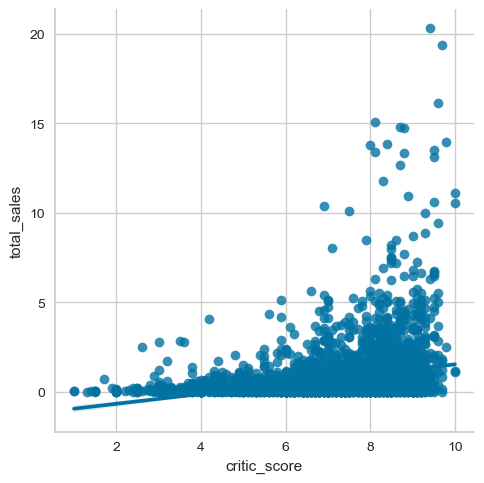

In [142]:
sb.lmplot(x='critic_score',y='total_sales',data=data_general_clean_date_q7,fit_reg=True) 

In [143]:
# X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=123, test_size=0.15) # random_state is like a seed for random generation

In [144]:
# the shape of the subsets
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(3504, 1)
(3504, 1)
(619, 1)
(619, 1)


## Train the ML Model

In [145]:
# creating an instance of Linear Regression model
myreg = LinearRegression()

In [146]:
# fit it to our data
myreg.fit(X_train, y_train)
myreg

LinearRegression()

In [147]:
# get the calculated coefficients
a = myreg.coef_
b = myreg.intercept_

In [148]:
a

array([[0.2817909]])

In [149]:
b

array([-1.25362977])

In [150]:
print(f"The model is a line, y = a * x + b, or y = {a} * x + {b}")

The model is a line, y = a * x + b, or y = [[0.2817909]] * x + [-1.25362977]


## Test the Models

### Test with the Test Data

In [151]:
y_predicted = myreg.predict(X_test)
y_predicted

array([[ 0.26804106],
       [ 0.85980194],
       [ 0.94433921],
       [-0.40825709],
       [ 0.71890649],
       [ 0.46529469],
       [ 0.57801105],
       [ 1.08523466],
       [ 0.09896652],
       [ 0.23986197],
       [ 1.14159284],
       [ 0.18350379],
       [-0.40825709],
       [ 0.77526467],
       [ 0.77526467],
       [ 0.91616012],
       [-0.04192892],
       [ 0.63436923],
       [ 0.52165287],
       [ 1.31066737],
       [ 0.09896652],
       [ 0.60619014],
       [ 0.60619014],
       [ 0.80344376],
       [ 0.66254831],
       [ 0.66254831],
       [ 0.52165287],
       [ 0.66254831],
       [ 0.4371156 ],
       [ 0.94433921],
       [ 0.71890649],
       [ 0.91616012],
       [ 0.66254831],
       [ 1.05705557],
       [ 0.4371156 ],
       [ 0.71890649],
       [ 1.05705557],
       [ 0.4371156 ],
       [ 0.60619014],
       [ 0.52165287],
       [-0.07010801],
       [ 0.54983196],
       [ 1.02887648],
       [ 1.33884646],
       [ 1.25430919],
       [ 0

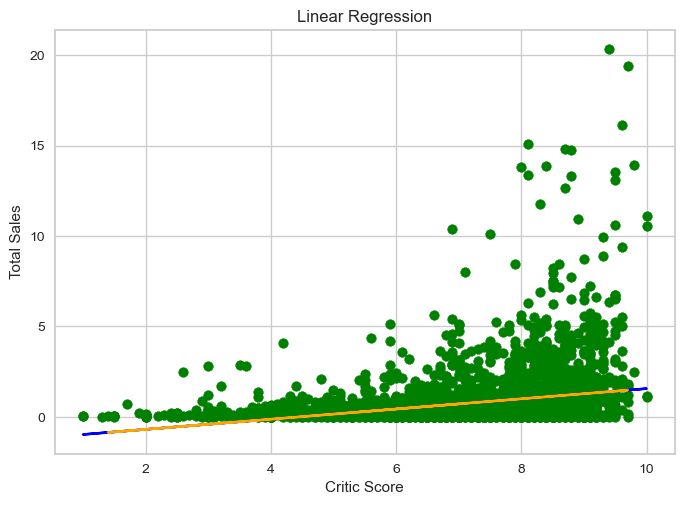

In [152]:
# Visualise the Linear Regression 
plt.title('Linear Regression')
plt.scatter(X, y, color='green')
plt.plot(X_train, a*X_train + b, color='blue')
plt.plot(X_test, y_predicted, color='orange')
plt.xlabel('Critic Score')
plt.ylabel('Total Sales')
plt.show()

## Model Evaluation 

We need evaluation metrics designed for comparing continuous values.

The **three common evaluation metrics** for regression problems:

- **Mean Absolute Error** (MAE) is the mean of the absolute value of the errors:

$$\frac 1n\sum_{i=1}^n|y_i-\hat{y}_i|$$

- **Mean Squared Error** (MSE) is the mean of the squared errors:

$$\frac 1n\sum_{i=1}^n(y_i-\hat{y}_i)^2$$

- **Root Mean Squared Error** (RMSE) is the square root of the mean of the squared errors:

$$\sqrt{\frac 1n\sum_{i=1}^n(y_i-\hat{y}_i)^2}$$

In [153]:
# MAE
from sklearn import metrics
mae = metrics.mean_absolute_error(y_test, y_predicted)
print(mae)

0.6499771446469941


In [154]:
# MSE
mse = metrics.mean_squared_error(y_test, y_predicted)
print(mse)

1.446734947339227


In [155]:
# RMSE
rmse = np.sqrt(metrics.mean_squared_error(y_test, y_predicted))
print(rmse)

1.2028029544938885


### Hypothesis for question 7:
We assume that games with a high critic score are also the games high total sales. Therefor, we expect to see a correlation between critic score and total sales.

### Observartion:

On average our prediction are off by 0.65-1.2 millions of units sold. Overall our model is a poor fit, especially for the majority of low-selling games. Our dataset has a lot of games with very low sales, so our distribution of games is heavily skewed towards that. If we wanted to make a better model we would have to normalize the total sales.